# GooglePlay Store Data Analytics

Author：Mia Lai 
Time：2023.7.18

## 1. Import packeages

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
import random
from PIL import Image
from wordcloud import WordCloud,ImageColorGenerator
import seaborn as sns
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import brown
from textblob import TextBlob
from plotly import graph_objs as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

## 2. Data Preprocessing

In [8]:
# 1.open googleplay store's all data's file and user's reviews' file, store as all and user respectively
filename1 = "googleplaystore.csv"
filename2 = "googleplaystore_user_reviews.csv"

all = pd.read_csv(filename1)
user = pd.read_csv(filename2)

# 2.data pre-processing
## data cleaning1: delete useless columns and rows
all = all.drop(['Unnamed: 0.4', 'Unnamed: 0.3','Unnamed: 0.2','Unnamed: 0.1','Unnamed: 0'], axis=1, inplace=False)
all = all.drop(labels=10472)
user = user.drop(['Unnamed: 0.3', 'Unnamed: 0.2','Unnamed: 0.1','Unnamed: 0'], axis=1, inplace=False)

## data cleaning2: delete missing values
all = all.fillna(value=0)
user = user.dropna(how='any')

## data cleaning3: change the data to a uniform format
all['Category'] = all['Category'].str.upper() # make sure all data is upper

user['Sentiment_Polarity'] = user['Sentiment_Polarity'].round(2) # keep two decimals
user['Sentiment_Subjectivity'] = user['Sentiment_Subjectivity'].round(2)

all['Reviews'] = all['Reviews'].astype('int64') # change object into int

## data cleaning4: Handling duplicated values and outliers
all = all.drop_duplicates() # clean all duplicated values
all = all.drop_duplicates(subset = 'App') # clean repeated rows that colname is App
user = user.drop_duplicates()

## 3. Data Analysis

### 3.1 Quantitative Analysis

#### 3.1.1 Top10 App Categories

In [9]:
#3.data analysing
## Top 10 categories by number of apps
top = all.groupby(all['Category'])["Category"].count()
sorted_top = top.sort_values(ascending=False)
top_ten = sorted_top[0:10]
top_ten = pd.DataFrame({'Number': top_ten})
top_ten.reset_index(inplace=True) # reset data type into dataframe
print(top_ten)

          Category  Number
0           FAMILY    1832
1             GAME     959
2            TOOLS     827
3         BUSINESS     420
4          MEDICAL     395
5  PERSONALIZATION     376
6     PRODUCTIVITY     374
7        LIFESTYLE     369
8          FINANCE     345
9           SPORTS     325


From the results, we can see that the most types of Google app Store apps are family-related apps, a total of 1,832, followed by game-related apps (959), the third is tools, the number of application types from four to ten is not very different.

Draw the top 10 bar charts by number of app categories as shown below:

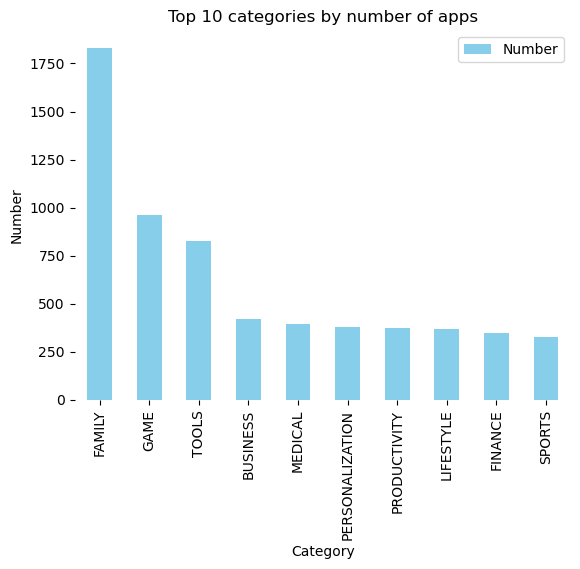

In [10]:
# Draw bar chart1
plt.rcParams['font.size'] = 10 # set fontsize
top_ten.plot.bar(x = "Category", y = "Number", title="Top 10 categories by number of apps", color='skyblue')
plt.title("Top 10 categories by number of apps")
plt.xlabel('Category',fontsize=10) 
plt.ylabel('Number', fontsize=10)
ax = plt.gca()
ax.set_axisbelow(True)
[ax.spines[loc_axis].set_visible(False) for loc_axis in ['bottom', 'top', 'left', 'right']]
plt.show()

#### 3.1.2 Top10 App Installations

In [11]:
## Find the top 10 most downloaded apps
all['Installs'] = all['Installs'].replace('free','0') # replace the value which is free into 0 in order to fit into int data type
all['Installs'] = all['Installs'].str.replace(',','') # clear the thousand separator
all['Installs'] = all['Installs'].str.replace('+','') # clear the end '+'
all['Installs'] = all['Installs'].astype("int64") # change data type into int
# all.info()
top_ten2 = all.nlargest(10, 'Installs')
top_ten2_results = top_ten2[['App', 'Installs']]
print(top_ten2_results)

                                           App    Installs
152                          Google Play Books  1000000000
335   Messenger – Text and Video Chat for Free  1000000000
336                         WhatsApp Messenger  1000000000
338               Google Chrome: Fast & Secure  1000000000
340                                      Gmail  1000000000
341                                   Hangouts  1000000000
391              Skype - free IM & video calls  1000000000
865                          Google Play Games  1000000000
1654                            Subway Surfers  1000000000
2544                                  Facebook  1000000000


The results show that the most installed app is Google Play Books, and four of the top 10 are instant-message-related apps - Messenger, WhatsApp, Skype, and Facebook - with all of the top 10 apps having more than 1 billion installs.

### 3.2 Distribution Analysis

#### 3.2.1 User Rating Distribution

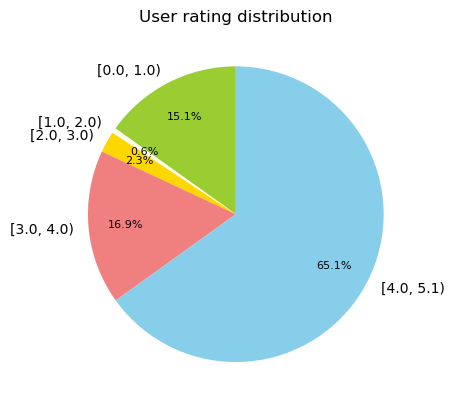

In [15]:
## User rating distribution
bins = [0.0, 1.0, 2.0, 3.0, 4.0, 5.1] # set segment
segments = pd.cut(all['Rating'], bins, right = False) # discretization of data by segment
# print(segments) 
counts = pd.value_counts(segments,sort = False ) # count the number of people in each section
# Draw pie chart1
colors = ['yellowgreen', 'Ivory', 'gold', 'lightcoral', 'skyblue'] # set color for each piece
distrpct1, l_text, p_text = plt.pie(counts,labels = counts.index.astype(str), autopct = '%1.1f%%', colors = colors, shadow = False, startangle = 90, pctdistance = 0.75)
for t in p_text: # change inside fontsize
    t.set_size(8)

for t in l_text: # change outside fontsize
    t.set_size(10)

plt.title('User rating distribution')
plt.show()

It can be seen from the results that the user's score is concentrated in more than 4 points, indicating that the vast majority of users are satisfied with the application they use. In addition, it is worth noting that the proportion of applications with a score below 1 is not less than, and users tend to be polarized when evaluating applications.

#### 3.2.2 User Review Distribution

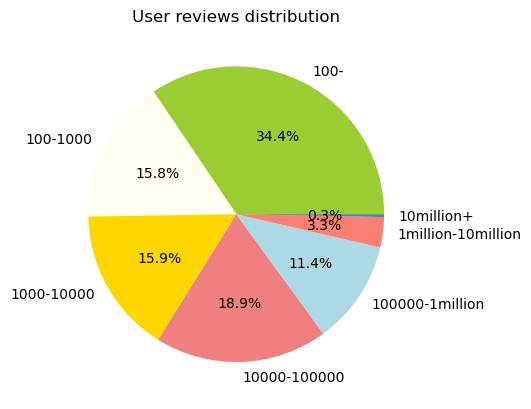

In [16]:
bins3 = [0, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000] # set segment
segments3 = pd.cut(all['Reviews'], bins3, right = False) # discretization of data by segment
# print(segments3)
counts3 = pd.value_counts(segments3,sort = False ) # count the number of people in each section
# print(counts3)
labels2 = ['100-', '100-1000', '1000-10000', '10000-100000', '100000-1million', '1million-10million', '10million+']
colors2 = ['yellowgreen', 'Ivory', 'gold', 'lightcoral', 'lightblue', 'salmon', 'steelblue'] # set color for each piece
distrpct3 = plt.pie(counts3,labels = labels2, autopct = '%1.1f%%', colors = colors2, shadow = False)
plt.title('User reviews distribution')
plt.show()

From the distribution of user reviews, it can be seen that there is little difference in the number of user comments in each interval, and the distribution is relatively average. The proportion of applications with less than 100 comments is relatively high, while the proportion of comments greater than 10 million is very small, indicating that users tend not to conduct text evaluation of applications

#### 3.2.3 Installed applications number (> 100 million) Distribution

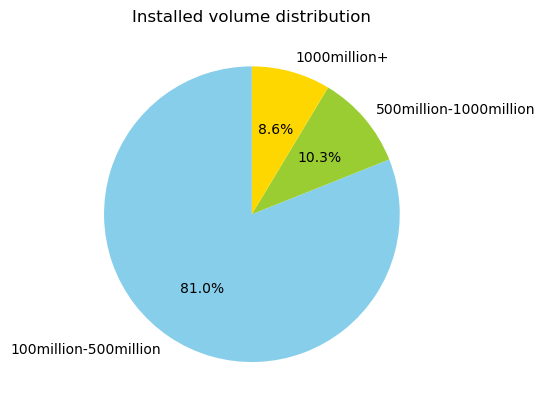

In [17]:
## Calculate the number of apps with more than 100 million installs, 100 million, 500 million, and 1 billion respectively
new_all = all[all['Installs']>=100000000]
bins2 = [100000000, 500000000, 1000000000, math.inf] # set segment
segments2 = pd.cut(new_all['Installs'], bins2, right = False) # discretization of data by segment
# print(segments2) 
counts2 = pd.value_counts(segments2,sort = False ) # count the number of people in each section
# print(counts2)
## draw a pie chart
colors2 = ['skyblue', 'yellowgreen', 'gold'] # set color for each piece
labels = ['100million-500million', '500million-1000million', '1000million+']
distrpct2 = plt.pie(counts2,labels = labels, autopct = '%1.1f%%', colors = colors2, shadow = False, startangle = 90)
plt.title('Installed volume distribution')
plt.show()

Among Apps with more than 100 million installations, the vast majority (81%) of Apps installations are concentrated in the 100-500 million range, and the more installations, the fewer Apps.

### 3.3 WordClous Analysis

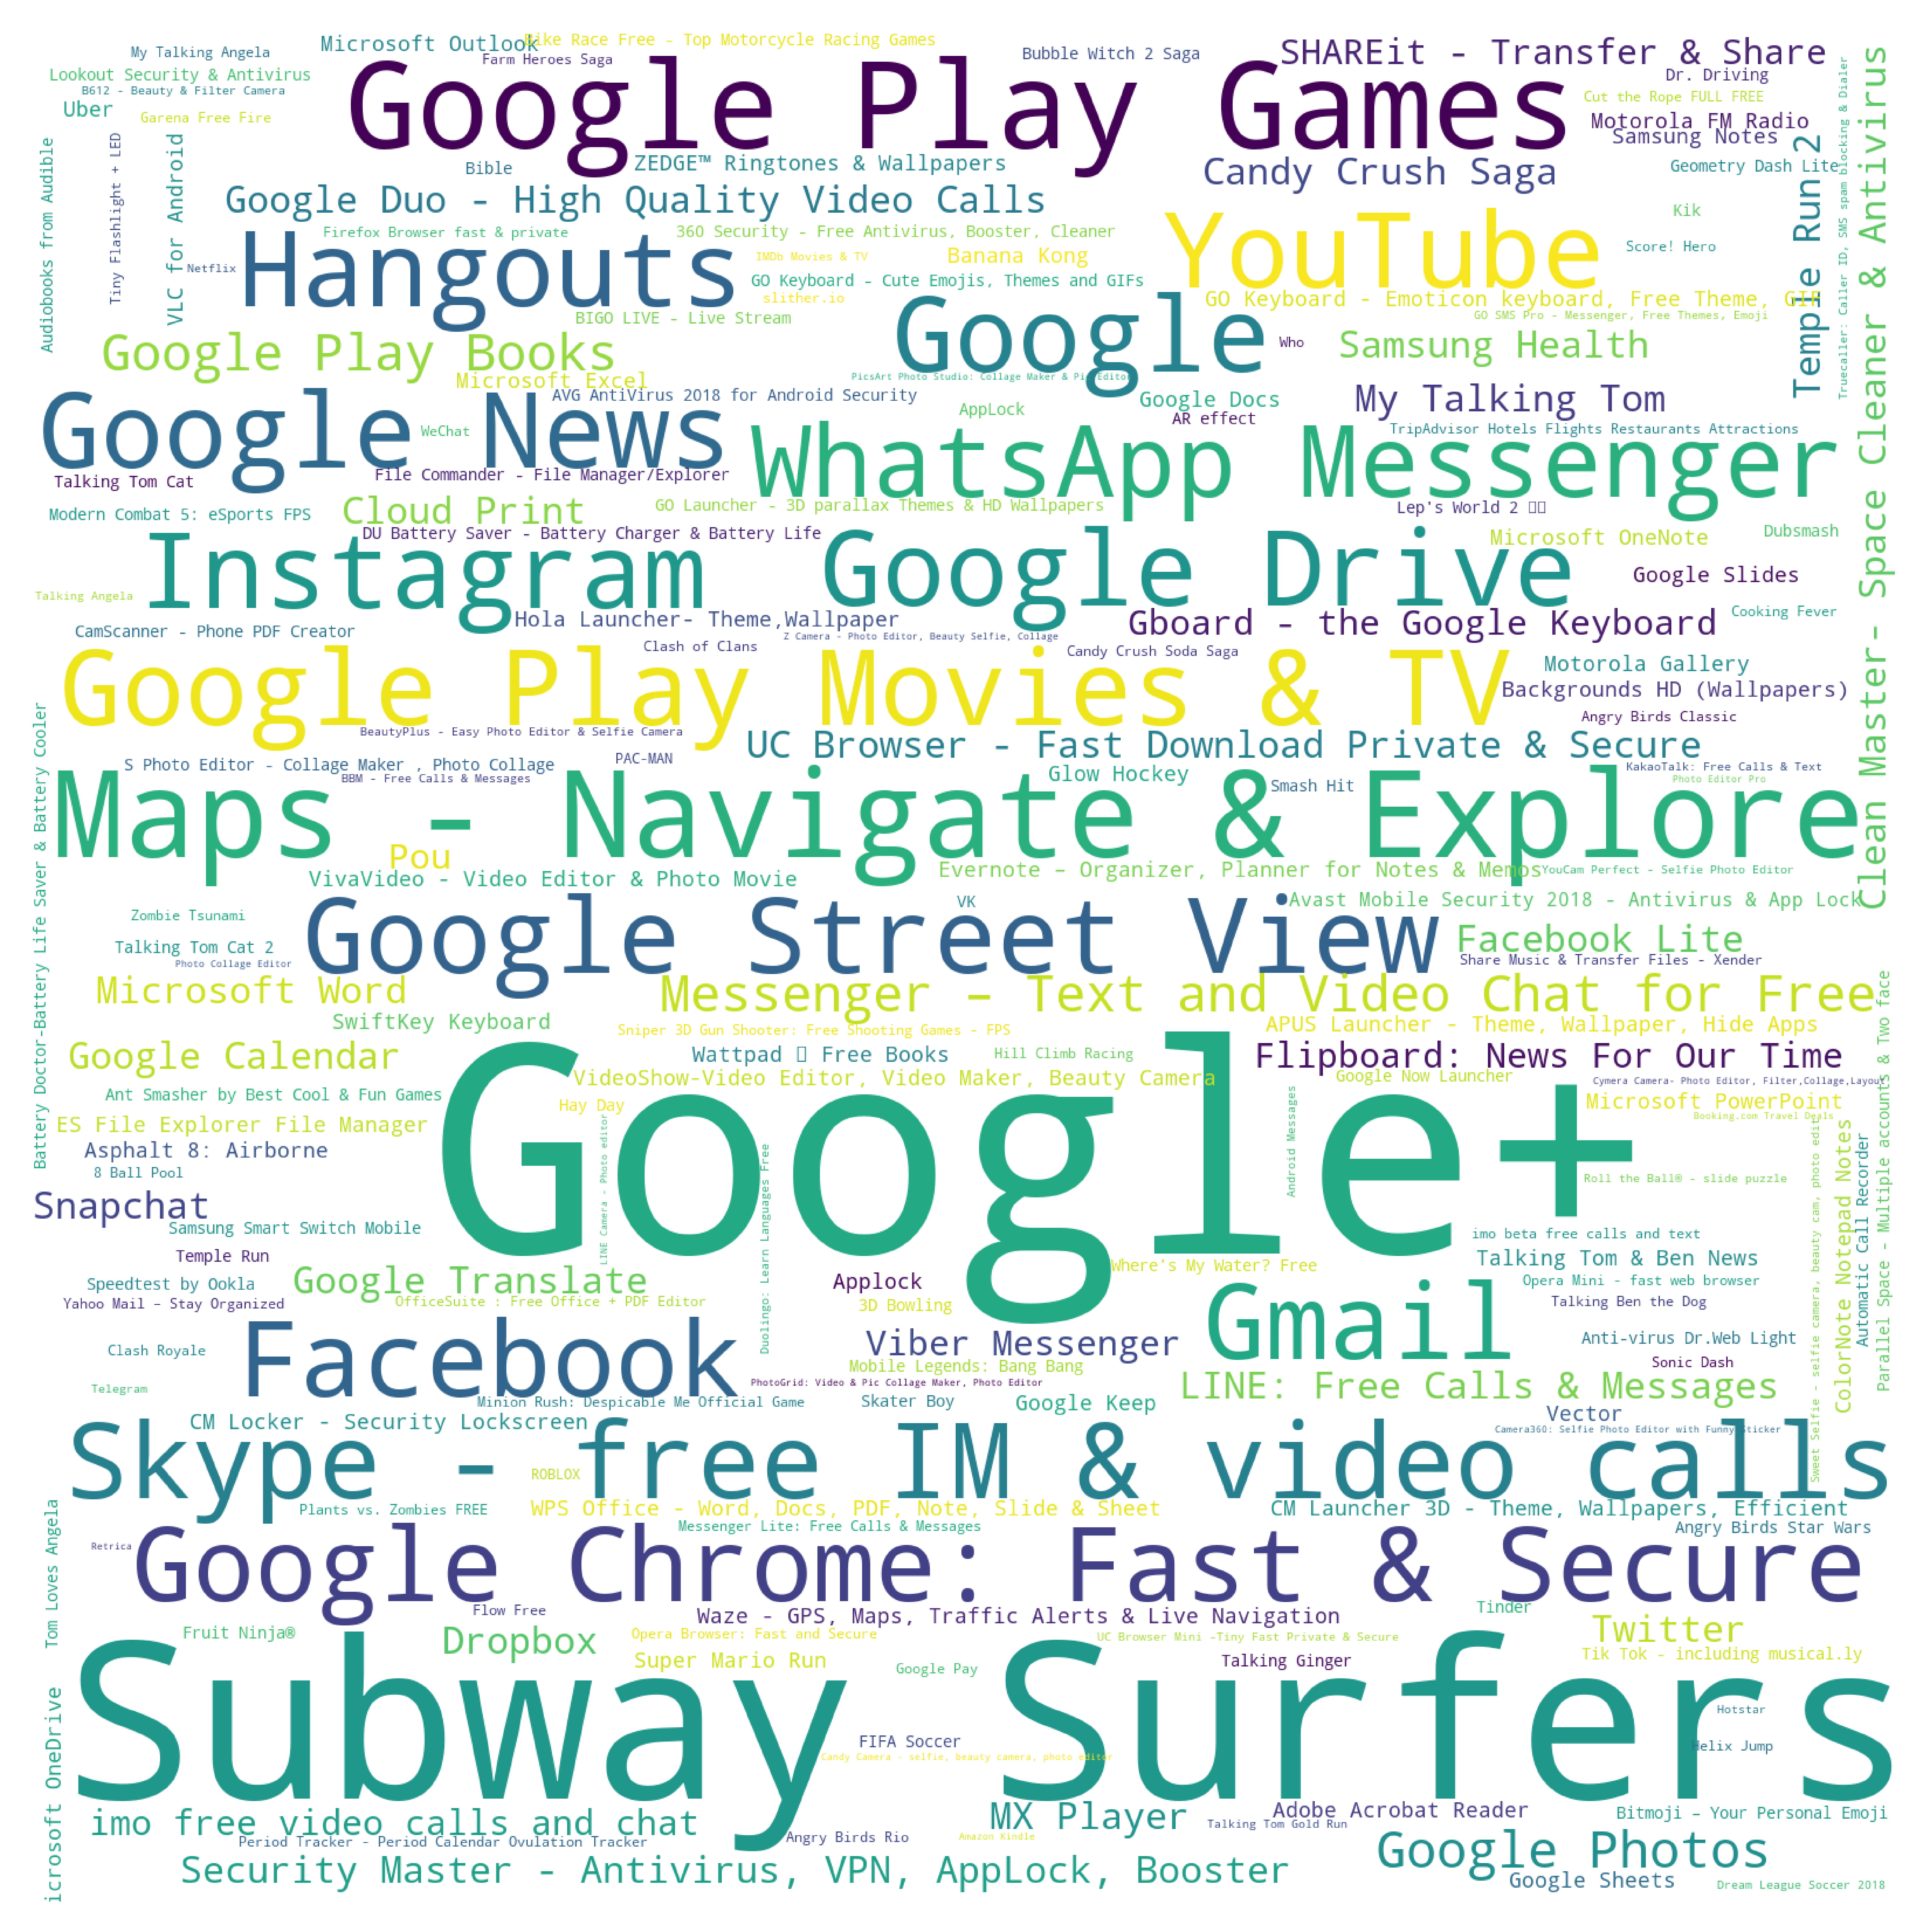

In [18]:
## make wordcloud using the rate of installed volume in apps whose installs are beyond 100million
wordcloud_org0 = new_all[['App', 'Installs']]
wordcloud_org = pd.DataFrame(index = wordcloud_org0['App']) # generate a new DF file
wordcloud_org['Installs'] = 0 # generate a column with values of 0, in preparation for the following assignment
for i in range(0, len(wordcloud_org0)):
      wordcloud_org.iloc[i,0] = wordcloud_org0.iloc[i,1]
wordcloud_org = wordcloud_org['Installs'].sort_values(ascending = False)
wordcloud_org = dict(wordcloud_org) # generate dict data type

# background_img = np.array(Image.open("1.jpeg"))
# img_colors = ImageColorGenerator(background_img)

plt.figure(figsize = (10,8), dpi = 1000)
# mask = plt.imread(r"1.jpeg")
wc = WordCloud(width = 800, height = 800, scale = 2, mode = "RGBA", background_color = 'white')
wc = wc.generate_from_frequencies(wordcloud_org)
# wc.recolor(color_func = img_colors)
plt.imshow(wc)
plt.axis('off')
plt.show()

From the word cloud, we can see that apps with more than 100 million installs have the name 'Google' the most frequently, followed by 'Subway' and 'Surfers', indicating that Google has the largest share of apps in the app Store.

### 3.4 Comparative analysis of free and paid apps

#### 3.4.1 Rating Comparison

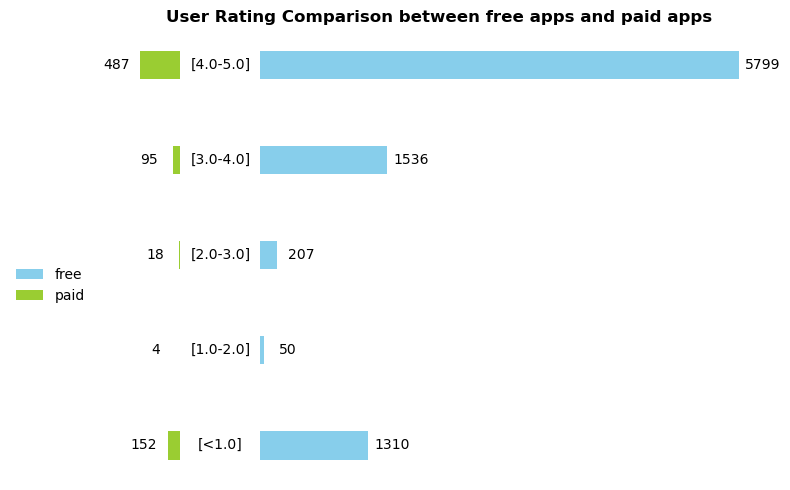

In [19]:
### Rating comparison
free_rating = all[all['Type'] == 'Free']
paid_rating = all[all['Type'] == 'Paid']
segments4_1 = pd.cut(free_rating['Rating'], bins, right = False) # discretization of data by segment
segments4_2 = pd.cut(paid_rating['Rating'], bins, right = False)
counts4_1 = pd.value_counts(segments4_1,sort = False ) # count the number of people in each section
counts4_2 = pd.value_counts(segments4_2,sort = False )
# print(counts4_1, counts4_2) 
# rating_compare = pd.DataFrame({'free': counts4_1, 'paid': counts4_2})
rating = ['[<1.0]','[1.0-2.0]', '[2.0-3.0]', '[3.0-4.0]', '[4.0-5.0]']
free = counts4_1.values.tolist() # change dataframe datatype into list
paid = counts4_2.values.tolist()

percent1 = round((counts4_1[3] + counts4_1[4]) / counts4_1.sum(),2)
percent2 = round((counts4_2[3] + counts4_2[4]) / counts4_2.sum(),2)
# print(percent1, percent2)
fix_value = [] # add a new fixed dimension
value_max = max(max(free), max(paid)) # fixed value equals to 1/6 max of free values and paid values
fix_temp = value_max / 6
for i in range(len(rating)):
      fix_value.append(fix_temp)
paid_ne = [-i for i in paid] # convert paid value into negative

plt.rcParams['font.size'] = 10 # set fontsize
plt.figure(figsize=(8,5)) # set picture size

# draw barh graph
plt.barh(rating, fix_value, color = 'w', height = 0.3) 
plt.barh(rating, free, left = fix_value, color = 'skyblue', label = 'free', height = 0.3)
plt.barh(rating, paid_ne, color = 'yellowgreen', label = 'paid', height = 0.3)

# add data tag, fix_value is represented by x values, free and paid are represented by data values
for a, b in zip(rating, fix_value):
      plt.text(b/2, a, '%s' % str(a), ha = 'center', va = 'center', fontsize = 10)
for a, b in zip(rating, free):
      plt.text(b + fix_temp + value_max / 20, a, '%d' % int(b), ha = 'center', va = 'center')
for a, b in zip(rating, paid):
      plt.text(-b - value_max / 20, a, '%d' % int(b), ha = 'center', va = 'center')

#set the axis scale not to display 
plt.xticks([])
plt.yticks([])

plt.legend(bbox_to_anchor=(-0.02, 0.5), frameon = False) # add legend

plt.title('User Rating Comparison between free apps and paid apps',fontsize = 12, fontweight = 'bold')

#set the painting area border not to show
ax = plt.gca()
ax.set_axisbelow(True)
[ax.spines[loc_axis].set_visible(False) for loc_axis in ['bottom', 'top', 'left', 'right']]

plt.tight_layout()
plt.show()

The results show that the overall distribution of free apps and paid apps is the same, showing a "high extreme value, low middle" distribution, the number of ratings above 4 is the largest, respectively calculated the number of free apps and paid apps ratings above 3 apps, free apps compared with paid apps overall user satisfaction is higher

#### 3.4.2 Installation Comparison

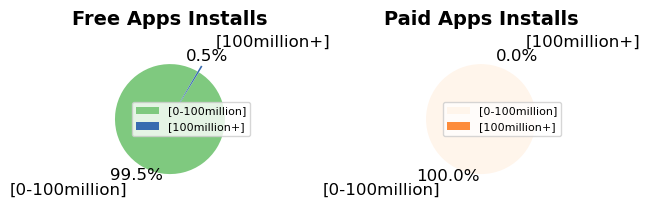

In [20]:
### installs comparison
free_installs = all[all['Type'] == 'Free']
paid_installs = all[all['Type'] == 'Paid']
counts5_1 = free_installs[free_installs['Installs'] > 100000000]['Installs'].count()
counts5_2 = free_installs[free_installs['Installs'] <= 100000000]['Installs'].count()
# print(counts5_1, counts5_2) 
free2 = [8858,44]
counts5_3 = paid_installs[paid_installs['Installs'] > 100000000]['Installs'].count()
counts5_4 = paid_installs[paid_installs['Installs'] <= 100000000]['Installs'].count()
# print(counts5_3, counts5_4) 
paid2 = [756,0]

install = ['[0-100million]','[100million+]']

plt.rcParams['font.size'] = 12 # set fontsize
fig,axes = plt.subplots(1,2)

sizes = free2
colors = cm.Accent(np.arange(len(sizes))/len(sizes)) # colormaps: Paired, autumn, rainbow, gray,spring,Darks
sizes2 = paid2
colors2 = cm.Oranges(np.arange(len(sizes2))/len(sizes2))

explode = (0,0.1)

# draw barh graph
axes[0].pie(free2,labels = install, explode = explode, autopct = '%1.1f%%', radius = 0.8, labeldistance=1.5, pctdistance=1.2, colors=colors, shadow = False, startangle = 60)
axes[0].set_title('Free Apps Installs', fontsize = 14, fontweight = 'bold')
axes[0].legend(loc = 'right',fontsize = 8) # add legend
axes[1].pie(paid2,labels = install, explode = explode, autopct = '%1.1f%%', radius = 0.8, labeldistance=1.5, pctdistance=1.2, colors=colors2, shadow = False, startangle = 60)
axes[1].set_title('Paid Apps Installs', fontsize = 14, fontweight = 'bold')
axes[1].legend(loc = 'right', fontsize = 8) # add legend

# set the axis scale not to display 
plt.xticks([])
plt.yticks([])

# set the painting area border not to show
ax = plt.gca()
ax.set_axisbelow(True)
[ax.spines[loc_axis].set_visible(False) for loc_axis in ['bottom', 'top', 'left', 'right']]

plt.tight_layout()
plt.show()

As can be seen from the results, the number of paid apps installed more than 100 million apps accounted for 0.5%, while the total number of paid apps installed less than 100 million, it can be seen that the paid apps user market is smaller than free apps, the number of users is low.

#### 3.4.3 Reviews Comparison

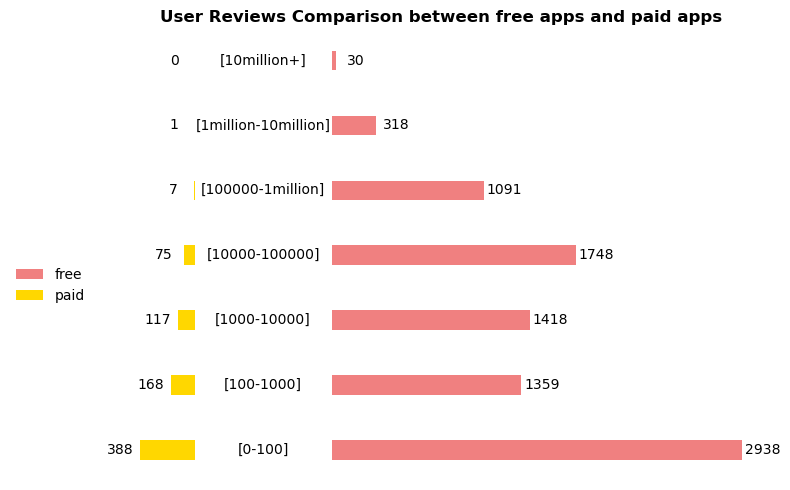

In [21]:
### Reviews comparison
free_Reviews = all[all['Type'] == 'Free']
paid_Reviews = all[all['Type'] == 'Paid']
segments5_1 = pd.cut(free_Reviews['Reviews'], bins3, right = False) # discretization of data by segment
segments5_2 = pd.cut(paid_Reviews['Reviews'], bins3, right = False)
counts5_1 = pd.value_counts(segments5_1,sort = False ) # count the number of people in each section
counts5_2 = pd.value_counts(segments5_2,sort = False )

free3 = counts5_1.values.tolist() # change dataframe datatype into list
paid3 = counts5_2.values.tolist()

Reviews = ['[0-100]', '[100-1000]', '[1000-10000]', '[10000-100000]', '[100000-1million]', '[1million-10million]', '[10million+]']
fix_value = [] # add a new fixed dimension
value_max = max(max(free3), max(paid3)) # fixed value equals to 1/6 max of free values and paid values
fix_temp = value_max / 3
for i in range(len(Reviews)):
      fix_value.append(fix_temp)
paid3_ne = [-i for i in paid3] # convert paid value into negative

plt.rcParams['font.size'] = 10 # set fontsize
plt.figure(figsize=(8,5)) # set picture size

# draw barh graph
plt.barh(Reviews, fix_value, color = 'w', height = 0.3) 
plt.barh(Reviews, free3, left = fix_value, color = 'lightcoral', label = 'free', height = 0.3)
plt.barh(Reviews, paid3_ne, color = 'Gold', label = 'paid', height = 0.3)

# add data tag, fix_value is represented by x values, free and paid are represented by data values
for a, b in zip(Reviews, fix_value):
      plt.text(b/2, a, '%s' % str(a), ha = 'center', va = 'center', fontsize = 10)
for a, b in zip(Reviews, free3):
      plt.text(b + fix_temp + value_max / 20, a, '%d' % int(b), ha = 'center', va = 'center')
for a, b in zip(Reviews, paid3):
      plt.text(-b - value_max / 20, a, '%d' % int(b), ha = 'center', va = 'center')

#set the axis scale not to display 
plt.xticks([])
plt.yticks([])

plt.legend(bbox_to_anchor=(-0.02, 0.5), frameon = False) # add legend

plt.title('User Reviews Comparison between free apps and paid apps',fontsize = 12, fontweight = 'bold')

#set the painting area border not to show
ax = plt.gca()
ax.set_axisbelow(True)
[ax.spines[loc_axis].set_visible(False) for loc_axis in ['bottom', 'top', 'left', 'right']]

plt.tight_layout()
plt.show()

As can be seen from the results, the number of free apps comments basically shows a gradual decrease trend, except for the range of 0-100, the number of comments also peaks between 10,000 and 100,000, the number of paid apps comments also decreases in general, and no apps exists in the range of more than 100 million comments, on the whole, users using free apps are more inclined to comment for apps.

#### 3.4.4 Apps Category Comparison

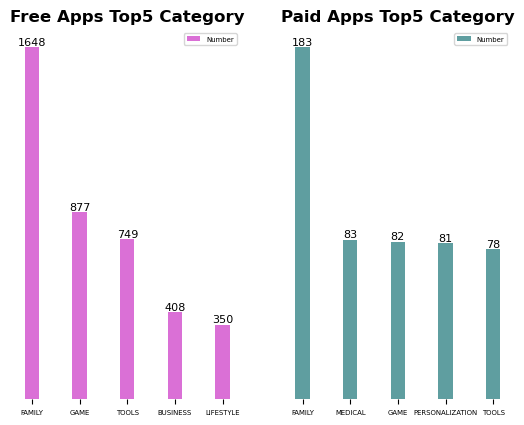

In [22]:
### Category number comparison
free_category = all[all['Type'] == 'Free']
paid_category = all[all['Type'] == 'Paid']
counts6_1 = free_category.groupby(free_category['Category'])['Category'].count()
sorted6_1 = counts6_1.sort_values(ascending=False)
top_free_c = sorted6_1[0:5]
counts6_2 = paid_category.groupby(paid_category['Category'])['Category'].count()
sorted6_2 = counts6_2.sort_values(ascending=False)
top_paid_c = sorted6_2[0:5]
number1 = top_free_c.index.astype(str)
number2 = top_paid_c.index.astype(str)
plt.rcParams['font.size'] = 5 # set fontsize
fig,axes = plt.subplots(1,2)
# draw barh graph
a1 = axes[0].bar(number1, top_free_c, width = 0.3, color = 'orchid')
axes[0].set_title('Free Apps Top5 Category', fontsize = 12, fontweight = 'bold')

a2 = axes[1].bar(number2, top_paid_c, width = 0.3, color = 'cadetblue')
axes[1].set_title('Paid Apps Top5 Category', fontsize = 12, fontweight = 'bold')

axes[0].bar_label(a1, label_type = 'edge', fontsize = 8) # add each data label
axes[1].bar_label(a2, label_type = 'edge', fontsize = 8)


#set legend
axes[0].legend(['Number'])
axes[1].legend(['Number'])

#set the painting area border not to show
axes[0].set_yticks([])
axes[1].set_yticks([])
[axes[0].spines[loc_axis].set_visible(False) for loc_axis in ['bottom', 'top', 'left', 'right']]
[axes[1].spines[loc_axis].set_visible(False) for loc_axis in ['bottom', 'top', 'left', 'right']]

plt.show()

It can be seen that the number of free apps and paid apps in the family category is the largest, free apps is more popular categories such as life and business, and the number of apps under different categories is different, while paid apps is more for personal, medical and other categories focusing on customization, and except for the peak category, there is little difference in the number of different categories.

### 3.5 Correlation Analysis

#### 3.5.1 Relationship between price, installation, and number of reviews

In [23]:
## correlation analysis
cor = all.loc[:, ['Price', 'Reviews', 'Installs']]
cor['Price'] = cor['Price'].str.replace('$','') # clear the beginning '$'
cor['Price'] = cor['Price'].astype("float64") # change data type into float

cor_result1 = cor.corr() # Above 0.5 is considered relevant
print(cor_result1)

             Price   Reviews  Installs
Price     1.000000 -0.007598 -0.009405
Reviews  -0.007598  1.000000  0.625165
Installs -0.009405  0.625165  1.000000


The results show that the correlation coefficient between the number of reviews and the number of installs is 0.625, and there is a positive correlation, while the price has no correlation with the number of installs and the number of reviews.

Draw a heat map as follows:

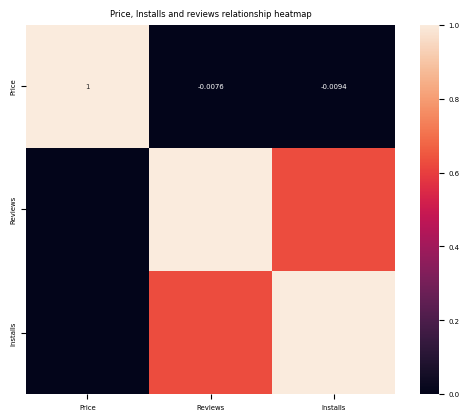

In [24]:
# draw heatmap
sns.heatmap(cor_result1, annot = True, vmax = 1, vmin = 0, xticklabels = True, yticklabels = True, square = True)
plt.title('Price, Installs and reviews relationship heatmap')
plt.show()

A scatter plot of price versus installations (using a sample size of 500) is shown below:

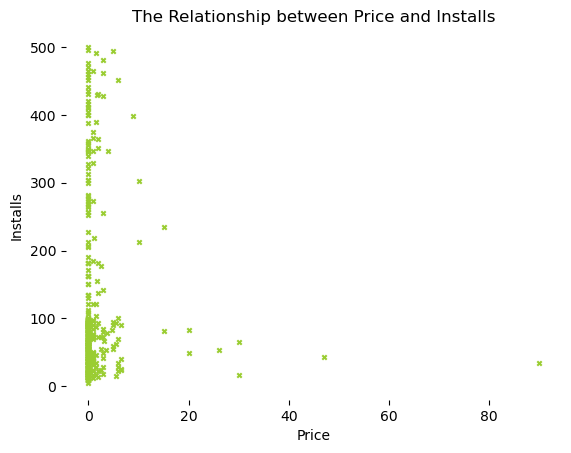

In [25]:
plt.rcParams['font.size'] = 10
all2 = cor.sort_values(['Installs', 'Price'], ascending = [False, True])
all2.reset_index(inplace=True)
all2['Installs2'] = 0
for i in range(0, len(all['Installs'])):
            all2['Installs2'][i] = random.randint(all2['Installs'][i], 10*all2['Installs'][i])
# print(all2['Installs2'])
plt.scatter(all2['Price'][9000:9500], all2['Installs2'][9000:9500], s = 10, marker = 'x', c = 'yellowgreen', cmap = None )
plt.title('The Relationship between Price and Installs')
plt.xlabel("Price")
plt.ylabel("Installs") 
ax = plt.gca()
ax.set_axisbelow(True)
[ax.spines[loc_axis].set_visible(False) for loc_axis in ['bottom', 'top', 'left', 'right']]
plt.show()

It can be seen that the installation is concentrated in the low price range.

A scatter chart of prices and ratings is shown below:

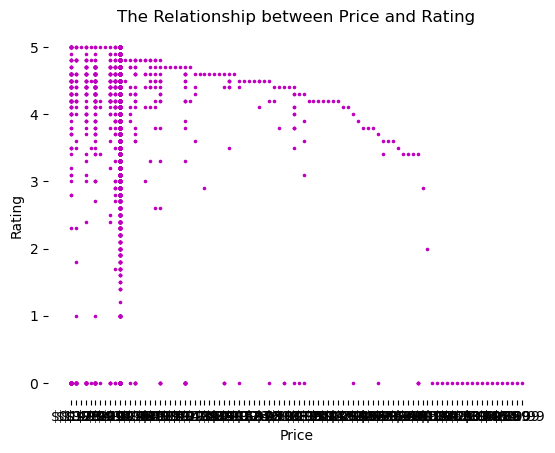

In [26]:
# all['Price'] = all['Price'].str.replace('$','') # clear the beginning '$'
# all['Price'] = all['Price'].astype("float64") # change data type into float
all3 = all.sort_values(['Rating', 'Price'], ascending = [False, True])
all3.reset_index(inplace=True)
plt.scatter(all3['Price'], all3['Rating'], s = 10, marker = '.', c = 'm', cmap = None )
plt.title('The Relationship between Price and Rating')
plt.xlabel("Price")
plt.ylabel("Rating") 
ax = plt.gca()
ax.set_axisbelow(True)
[ax.spines[loc_axis].set_visible(False) for loc_axis in ['bottom', 'top', 'left', 'right']]
plt.show()

As can be seen, the ratings for free apps are higher and more focused.

The scatterplot of ratings and app sizes is shown below:

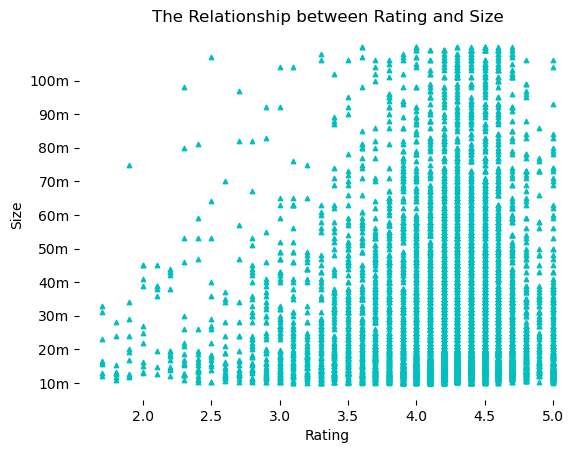

In [27]:
all4 = all[~all['Size'].isin(['Varies with device'])]
all4['Size'] = all4['Size'].str.replace('M','')
for i in range(len(all4['Size'].values)):
      if(all4['Size'].values[i][-1]=='k'):
            all4['Size'].values[i] = all4['Size'].values[i].replace('k','')
            all4['Size'].values[i] = float(all4['Size'].values[i])
            all4['Size'].values[i] = all4['Size'].values[i] / 1000
all4 = all4.sort_values(['Rating', 'Size'], ascending = [False, True])
all4.reset_index(inplace=True)
plt.scatter(all4['Rating'][0:7000],all4['Size'][0:7000], s = 10, marker = '^', c = 'c', cmap = None )
plt.title('The Relationship between Rating and Size')
plt.yticks(range(0,100,10), labels = ['10m', '20m', '30m', '40m', '50m', '60m', '70m', '80m', '90m', '100m'])
plt.xlabel("Rating")
plt.ylabel("Size")
ax = plt.gca()
ax.set_axisbelow(True)
[ax.spines[loc_axis].set_visible(False) for loc_axis in ['bottom', 'top', 'left', 'right']]
plt.show()

It can be seen that the higher the application score, the smaller the application, and the application is concentrated in the area with small application volume and high score.

### 3.6 Sentimental Analysis

In [28]:
# 1.open googleplay store's all data's file and user's reviews' file, store as all and user respectively
filename = "googleplaystore_user_reviews.csv"

user = pd.read_csv(filename)

# 2.data pre-processing
## data cleaning1: delete useless columns and rows
user = user.drop(['Unnamed: 0.3', 'Unnamed: 0.2','Unnamed: 0.1','Unnamed: 0'], axis=1, inplace=False)

## data cleaning2: delete missing values
user = user.dropna(how='any')

## data cleaning3: change the data to a uniform format
user['Sentiment_Polarity'] = user['Sentiment_Polarity'].round(2) # keep two decimals
user['Sentiment_Subjectivity'] = user['Sentiment_Subjectivity'].round(2)

## data cleaning4: Handling duplicated values and outliers
user = user.drop_duplicates()

In [29]:
user.info()
print(user.head(10))

<class 'pandas.core.frame.DataFrame'>
Index: 29692 entries, 0 to 64230
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   App                     29692 non-null  object 
 1   Translated_Review       29692 non-null  object 
 2   Sentiment               29692 non-null  object 
 3   Sentiment_Polarity      29692 non-null  float64
 4   Sentiment_Subjectivity  29692 non-null  float64
dtypes: float64(2), object(3)
memory usage: 1.4+ MB
                      App                                  Translated_Review  \
0   10 Best Foods for You  I like eat delicious food. That's I'm cooking ...   
1   10 Best Foods for You    This help eating healthy exercise regular basis   
3   10 Best Foods for You         Works great especially going grocery store   
4   10 Best Foods for You                                       Best idea us   
5   10 Best Foods for You                                           Best w

In [30]:
user['Translated_Review'] = user['Translated_Review'].replace('""',' ')
user['Translated_Review']

0        I like eat delicious food. That's I'm cooking ...
1          This help eating healthy exercise regular basis
3               Works great especially going grocery store
4                                             Best idea us
5                                                 Best way
                               ...                        
64222    Most ads older many agents ..not much owner po...
64223    If photos posted portal load, fit purpose. I'm...
64226    Dumb app, I wanted post property rent give opt...
64227    I property business got link SMS happy perform...
64230    Useless app, I searched flats kondapur, Hydera...
Name: Translated_Review, Length: 29692, dtype: object

In [31]:
user_l = list(user['Translated_Review'])

In [32]:
user0 = user[['App', 'Translated_Review']]
user0 = pd.concat([user0, pd.DataFrame(columns=['sentiment'])])
user0 = pd.concat([user0, pd.DataFrame(columns=['sentiment_Polarity'])])
sid = SentimentIntensityAnalyzer()
for i in range(len(user_l)):
    sentiment = sid.polarity_scores(user_l[i])
    user0.loc[i,'sentiment_Polarity'] = sentiment['compound']
    if sentiment['compound'] > 0:
        user0.loc[i,'sentiment'] = 'Positive'
    elif sentiment['compound'] < 0:
        user0.loc[i,'sentiment'] = 'Negative'
    else:
        user0.loc[i,'sentiment'] = 'Neutral'

In [33]:
user0 = user0.dropna(how='any')
user0

,App,Translated_Review,sentiment,sentiment_Polarity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,0.9531
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.6597
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.6369
4,10 Best Foods for You,Best idea us,Positive,0.6369
5,10 Best Foods for You,Best way,Positive,0.5859
...,...,...,...,...
29687,Couple - Relationship App,"Greatest kind, get greater? Love app. I contin...",Negative,-0.6486
29688,Couple - Relationship App,Fix please! Me bf communicate nowadays. And An...,Positive,0.743
29689,Couple - Relationship App,Needs update guys! Messages take awhile receiv...,Negative,-0.7269
29690,Couple - Relationship App,"Great App, Need help 3 things The calendar dec...",Positive,0.7783


In [34]:
user0.to_excel('sentiment1.xlsx', sheet_name='sheet1', index=False)

In [35]:
user1 = user[['App', 'Translated_Review']]
user1 = pd.concat([user1, pd.DataFrame(columns=['sentiment'])])
user1 = pd.concat([user1, pd.DataFrame(columns=['sentiment_Polarity'])])
user1 = pd.concat([user1, pd.DataFrame(columns=['sentiment_Subjectivity'])])
for i in range(len(user_l)):
    blob = TextBlob(user_l[i])
    sentiment = blob.sentiment.polarity
    user1.loc[i,'sentiment_Polarity'] = sentiment
    user1.loc[i,'sentiment_Subjectivity'] = blob.sentiment.subjectivity
    if sentiment > 0:
        user1.loc[i,'sentiment'] = 'Positive'
    elif sentiment < 0:
        user1.loc[i,'sentiment'] = 'Negative'
    else:
        user1.loc[i,'sentiment'] = 'Neutral'

In [36]:
user1 = user1.dropna(how='any')
user1

,App,Translated_Review,sentiment,sentiment_Polarity,sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.0,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,1.0,0.3
4,10 Best Foods for You,Best idea us,Positive,1.0,0.3
5,10 Best Foods for You,Best way,Positive,0.6,0.9
...,...,...,...,...,...
29687,Couple - Relationship App,"Greatest kind, get greater? Love app. I contin...",Positive,0.173333,0.486667
29688,Couple - Relationship App,Fix please! Me bf communicate nowadays. And An...,Positive,0.225,0.447222
29689,Couple - Relationship App,Needs update guys! Messages take awhile receiv...,Negative,-0.2875,0.25
29690,Couple - Relationship App,"Great App, Need help 3 things The calendar dec...",Positive,0.8,1.0


In [51]:
temp = user1.groupby('sentiment').count()['Translated_Review'].reset_index().sort_values(by='Translated_Review',ascending=False)
temp.style.background_gradient(cmap='Blues')

,sentiment,Translated_Review
2,Positive,8977
0,Negative,3095
1,Neutral,1996


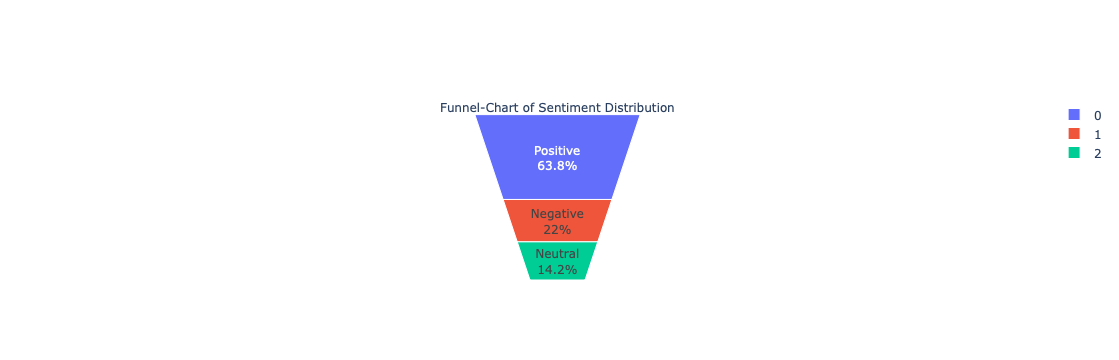

In [47]:
fig = go.Figure(go.Funnelarea(
    text =temp.sentiment,
    values = temp.Translated_Review,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

We can see the majority of reviews are positive, indicating good customer satisfaction with the product or service being reviewed. The negative reviews, while fewer, still represent a significant number of customers. Analyzing the content of these negative reviews could provide insights into areas for improvement.

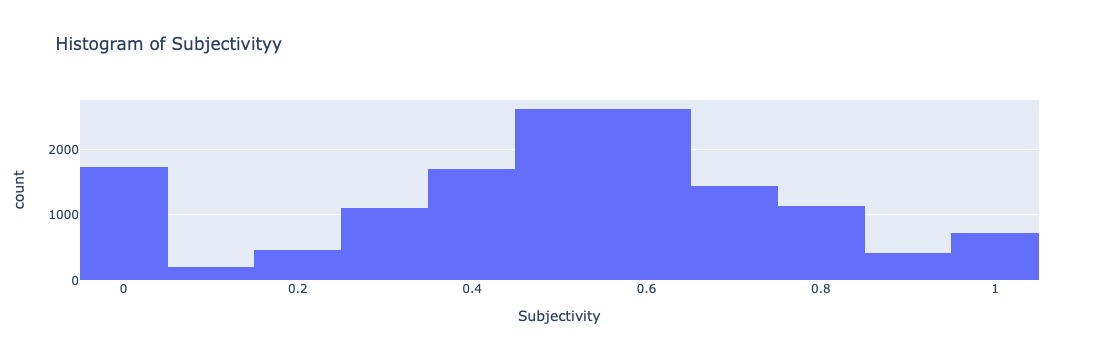

In [58]:
# Histogram for Sensitivity
fig_hist_sensitivity = px.histogram(user1, x='sentiment_Subjectivity', nbins=20,
                                    title='Histogram of Subjectivity',
                                    labels={'sentiment_Subjectivity': 'Subjectivity'})
fig_hist_sensitivity.show()

There is a significant number of entries in the 0 bin, indicating a large amount of text data is classified as completely objective.

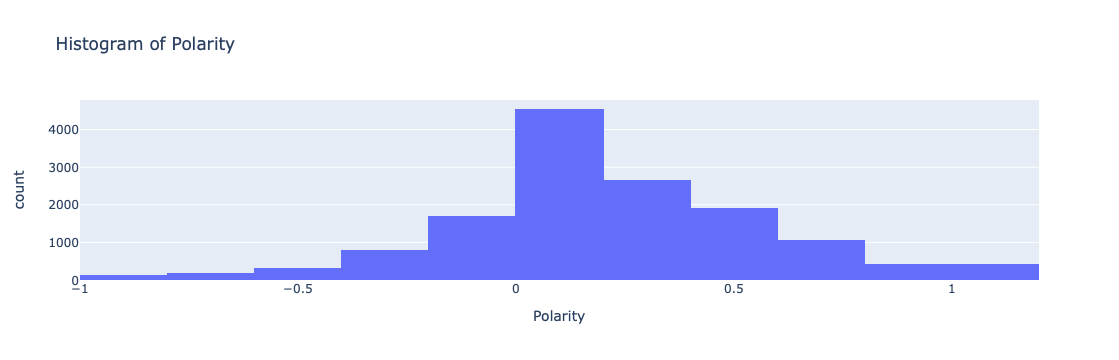

In [59]:
# Histogram for Polarity
fig_hist_sensitivity = px.histogram(user1, x='sentiment_Polarity', nbins=20,
                                    title='Histogram of Polarity',
                                    labels={'sentiment_Polarity': 'Polarity'})
fig_hist_sensitivity.show()

Both positive and negative extremes have fewer counts compared to the neutral category, indicating that strongly polarized sentiments are less common.

In [89]:
## Fidn apps whose negative reviews percentages are higher than 50%
app_negative_percentage = user1[user1['sentiment'] == 'Negative'].groupby('App').size() / user1.groupby('App').size() * 100

# Convert to DataFrame for better display and reset index
app_negative_percentage = app_negative_percentage.reset_index(name='Negative_Reviews_Percentage').sort_values(by = 'Negative_Reviews_Percentage', ascending = False)

app_negative_percentage[app_negative_percentage['Negative_Reviews_Percentage'] >= 50].style.background_gradient(cmap='PuBuGn')
# temp[:5].style.background_gradient(cmap='Blues')

,App,Negative_Reviews_Percentage
49,ASUS Quick Memo,100.000000
123,Apartment Decorating Ideas,100.000000
321,Caller ID +,100.000000
281,Buscapé - Ofertas e descontos,66.666667
367,Citizens Bank Mobile Banking,61.538462
172,Baby ABC in box! Kids alphabet games for toddlers!,61.111111
173,Baby Monitor,60.000000
171,Babbel – Learn Spanish,58.974359
363,Cisco Webex Meetings,58.974359
52,"AT&T Navigator: Maps, Traffic",58.620690


With over 50% negative reviews, these apps may have significant issues affecting user experience. It could be due to functionality problems, poor design, performance issues, or lack of desired features.

## 4. Summary and suggestion

### 4.1 Summary

From the above data analysis, we can see:

(1) In terms of application category and quantity, the vast majority of applications in Google App Store are practical and entertainment applications such as family life, games and tools, and the most downloaded and installed applications are related to instant messaging;

(2) In terms of distribution, users' ratings are concentrated in high scores while the number of comments is concentrated in a small number, indicating that users are more inclined to rate apps. The installed amount of apps with more than 100 million installs is not significantly different, and the distribution is balanced;

(3) In terms of word cloud statistics, the main applications on Google App Store are Google's internal software, followed by communication brands;

(4) Compared with paid software, free software has a higher user base and user satisfaction, and can arouse more passion among users;

(5) In terms of variable relationship, the number of reviews is positively correlated with the number of installs, that is, apps with more reviews have more installs. In addition, apps with more installs are basically free or cheap apps, and these apps have relatively high scores and occupy less space.

(6) Overall, the majority of GooglePlay Store Apps' reviews are positive, indicating a relatively high user satisfactions.

### 4.2 Suggestion

Software developers targeting the Google App Store should focus more on developing affordable and small utility applications, especially those related to messaging and instant messaging. For the staff who maintain and improve the Google App Store, they should focus on improving the convenience of user ratings, such as adding associative statements when commenting, to better promote user reviews and help other users better understand interested users.


For those Apps that have percentages of negative reviews are higher than 50%, there are some suggestion for improvemnet:

(1) Customer Service: The companies might need to invest in customer service and support to address user complaints.

(2) App Updates: Regular updates and bug fixes may be needed to improve app performance and address users' negative feedback.

(3) Feature Enhancement: These high percentages suggest that users might be finding the apps lacking in terms of features or usability. Enhancing features could help in reducing negative feedback.